Part B

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/10
24/24 [==============================] - 48s 1s/step - loss: 0.1418 - accuracy: 0.9584 - val_loss: 0.0461 - val_accuracy: 0.9893
Epoch 2/10
24/24 [==============================] - 14s 592ms/step - loss: 0.0452 - accuracy: 0.9893 - val_loss: 0.0423 - val_accuracy: 0.9893
Epoch 3/10
24/24 [==============================] - 15s 608ms/step - loss: 0.0421 - accuracy: 0.9893 - val_loss: 0.0396 - val_accuracy: 0.9893
Epoch 4/10
24/24 [==============================] - 13s 546ms/step - loss: 0.0407 - accuracy: 0.9893 - val_loss: 0.0394 - val_accuracy: 0.9893
Epoch 5/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0403 - accuracy: 0.9893 - val_loss: 0.0388 - val_accuracy: 0.9893
Epoch 6/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0405 - accuracy: 0.9893 - val_loss: 0.0387 - val_accuracy: 0.9894
Epoch 7/10
24/24 [==============================] - 14s 594ms/step - loss: 0.0401 - accuracy: 0.9893 - val_loss: 0.0381 - val_accuracy: 0.9893
Ep

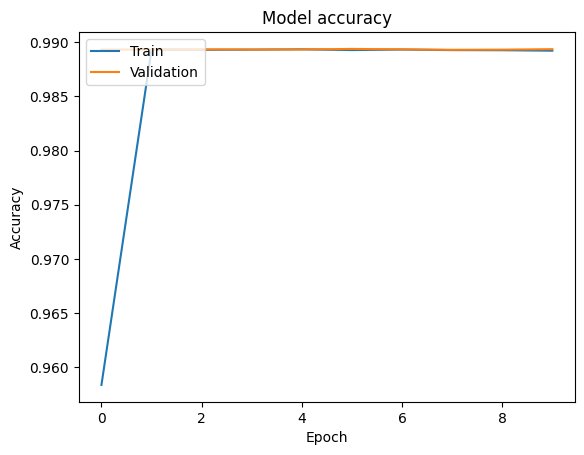

In [7]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_DIR = '/content/drive/MyDrive/Task - Segmentation-20240128T101536Z-001/Task - Segmentation/images'
MASK_DIR = '/content/drive/MyDrive/Task - Segmentation-20240128T101536Z-001/Task - Segmentation/masks'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 10
TEST_SPLIT = 0.10 # Percentage of data to use for testing
VAL_SPLIT = 0.3 # Percentage of data to use for validation

# Load images and masks
image_files = os.listdir(IMAGE_DIR)
mask_files = os.listdir(MASK_DIR)
image_files.sort()
mask_files.sort()

images = []
masks = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255.0  # Normalize

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask / 255.0  # Normalize

    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=TEST_SPLIT, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SPLIT, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Define U-Net model
def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)

    concat1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = unet_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) // BATCH_SIZE
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save('cranium_segmentation_model.h5')
model.save_weights('Part_B_model_weights_hypothesis.h5')
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()